In [35]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from tqdm import tqdm
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.manifold import MDS

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

RAND = 0
RESP = (50,220)
BASE = (-50,0)
ONSET = 50
RESP = slice(ONSET + RESP[0], ONSET + RESP[1])
BASE = slice(ONSET + BASE[0], ONSET + BASE[1])

In [4]:
DATA_DIR = '../../datasets/NNN/'
dat = pd.read_pickle(os.path.join(DATA_DIR, ('face_roi_data.pkl')))
print(f'Unique face ROIs: {list(dat['roi'].unique())}')

Unique face ROIs: ['Unknown_19_F', 'MF1_9_F', 'MF1_8_F', 'AF3_18_F', 'MF1_7_F', 'Unknown_5_F', 'AMC3_28_F']


In [21]:
def geo_rdm(dat, roi, mode='top', step=5, k_max=200, metric='correlation'):
    rng = np.random.default_rng(RAND)
    sig = dat[dat['p_value'] < 0.05]
    df = sig[sig['roi'] == roi]
    if len(df) == 0:
        raise ValueError(f"No data for ROI {ROI}")
    X = np.stack(df['img_psth'].to_numpy())          # (units, time, images)

    scores = np.nanmean(X[:, RESP, :], axis=(0,1)) - np.nanmean(X[:, BASE, :], axis=(0,1))
    order = np.argsort(scores)[::-1] if mode == 'top' else rng.permutation(scores.size)

    # ================= choose the image-set bins to calculate RDMs ========
    sizes = [k for k in range(step, min(k_max, X.shape[2]) + 1, step)]
    # =================== ramping step size ================================ 
    # sizes = [k for k in range(1, 2*step)] + [k for k in range(2*step, min(k_max, X.shape[2])+1, step)]
    
    rdvs = []
    for k in tqdm(sizes):
        idx = order[:k]
        Ximg = X[:, :, idx] # (units, time, images)
        Xrdv = np.array([pdist(Ximg[:, t, :].T, metric='correlation') for t in range(Ximg.shape[1])])
        R = squareform(pdist(Xrdv, metric=metric))   # (time, time)
        rdvs.append(R)
    return sizes, rdvs

def rdvs(dat, roi, mode='top', step=5, k_max=200, metric='correlation'):
    rng = np.random.default_rng(RAND)
    sig = dat[dat['p_value'] < 0.05]
    df = sig[sig['roi'] == roi]
    if len(df) == 0:
        raise ValueError(f"No data for ROI {ROI}")
    X = np.stack(df['img_psth'].to_numpy())          # (units, time, images)

    scores = np.nanmean(X[:, RESP, :], axis=(0,1)) - np.nanmean(X[:, BASE, :], axis=(0,1))
    order = np.argsort(scores)[::-1] if mode == 'top' else rng.permutation(scores.size)

    # ================= choose the image-set bins to calculate RDMs ========
    sizes = [k for k in range(step, min(k_max, X.shape[2]) + 1, step)]
    # =================== ramping step size ================================ 
    # sizes = [k for k in range(1, 2*step)] + [k for k in range(2*step, min(k_max, X.shape[2])+1, step)]
    
    rdvs = []
    for k in tqdm(sizes):
        idx = order[:k]
        Ximg = X[:, :, idx] # (units, time, images)
        Xrdv = np.array([pdist(Ximg[:, t, :].T, metric='correlation') for t in range(Ximg.shape[1])])
        rdvs.append(Xrdv)
    return sizes, rdvs

'''
THESE TWO FUNCTIONS MAKE RDMs USING A SINGEL SET OF IMAGES
 (AS OPPOSED TO THE TOP/SHUFFLED)
'''
def gain(dat, roi, img_sets, mode='top', step=5, k_max=200, metric='correlation'):
    sig = dat[dat['p_value'] < 0.05]
    df = sig[sig['roi'] == roi]
    if len(df) == 0:
        raise ValueError(f"No data for ROI {ROI}")
    X = np.stack(df['img_psth'].to_numpy())          # (units, time, images)

    rdvs = {}
    for k,v in img_sets.items():
        Ximg = X[:, :, v]
        Ximg = np.mean(Ximg, axis=0)
        R = squareform(pdist(Ximg, metric=metric))
        rdvs[k] = R
    return rdvs

def geom(dat, roi, img_sets, mode='top', step=5, k_max=200, metric='correlation'):
    sig = dat[dat['p_value'] < 0.05]
    df = sig[sig['roi'] == roi]
    if len(df) == 0:
        raise ValueError(f"No data for ROI {ROI}")
    X = np.stack(df['img_psth'].to_numpy())          # (units, time, images)

    rdvs = {}
    time_rdvs = {}
    for k,v in img_sets.items():
        Ximg = X[:, :, v]
        Xrdv = np.array([pdist(Ximg[:, t, :].T, metric='correlation') for t in range(Ximg.shape[1])])
        time_rdvs[k] = Xrdv
        R = squareform(pdist(Xrdv, metric=metric))
        rdvs[k] = R
    return rdvs, time_rdvs

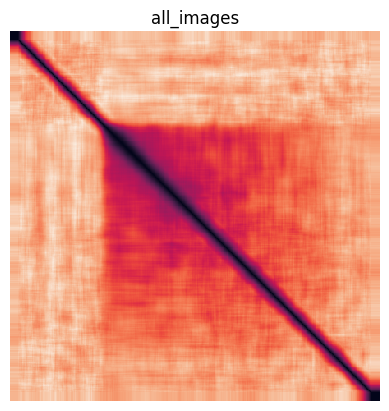

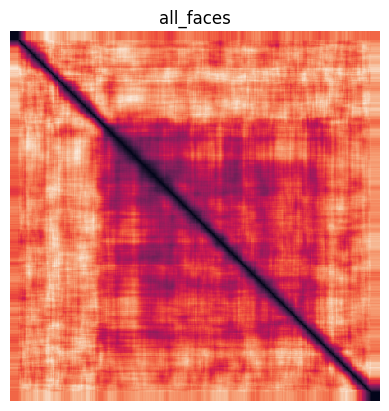

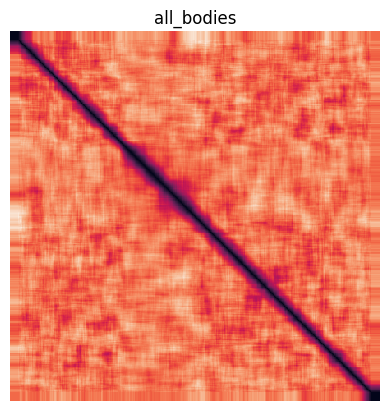

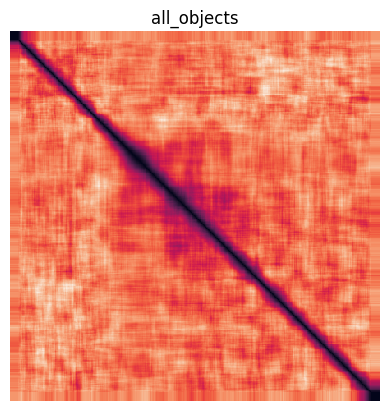

In [42]:
_roi = 'MF1_9_F' # MF1_8_F, Unknown_19_F, MF1_7_F

img_sets = {
    'all_images': np.arange(1000, 1072),
    "all_faces":  np.arange(1000, 1024),
    # 'monkey faces':  np.concatenate([np.arange(1000,1006), np.arange(1009,1016)]),
    # 'human faces': np.concatenate([np.arange(1006,1009), np.arange(1016,1025)]),
    "all_bodies": np.concatenate([
        np.arange(1025, 1031),
        np.arange(1042, 1048),
        np.arange(1049, 1061)
    ]),
    "all_objects": np.concatenate([
        np.arange(1024,1025),
        np.arange(1031, 1042),
        np.arange(1048,1049),
        np.arange(1061, 1072)
    ])
}

rdms, Xrdv = geom(dat, _roi, img_sets)

for k,v in rdms.items():
    fig,ax = plt.subplots(1,1)
    sns.heatmap(v, square = True, cbar=False, ax=ax)
    ax.set_axis_off()
    ax.set_title(k)
    plt.show()

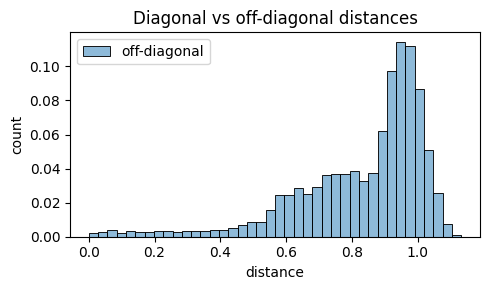

In [34]:
R = rdms['all_images']
diag_vals = np.diag(R)
off_vals  = R[~np.eye(R.shape[0], dtype=bool)]

plt.figure(figsize=(5,3))
sns.histplot(off_vals, bins=40, stat='probability', alpha=0.5, label="off-diagonal")
# sns.histplot(diag_vals, bins=40, stat='probability', alpha=0.5, label="on-diagonal")
plt.legend(); plt.xlabel("distance"); plt.ylabel("count")
plt.title("Diagonal vs off-diagonal distances")
plt.tight_layout(); plt.show()

# plt.figure(figsize=(5,3))
# plt.plot(diag_vals, label="diag")
# plt.plot(off_vals[::len(diag_vals)], alpha=0.4, label="sampled off-diag")
# plt.legend(); plt.tight_layout(); plt.show()

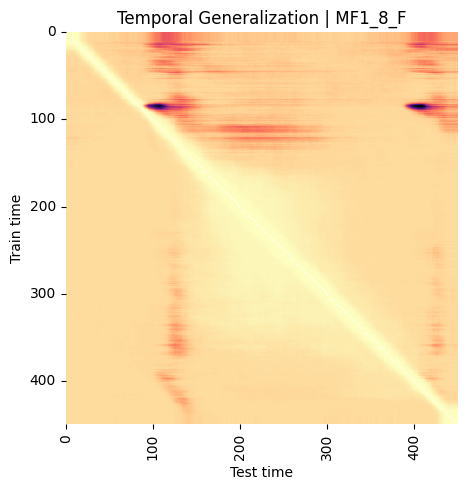

/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


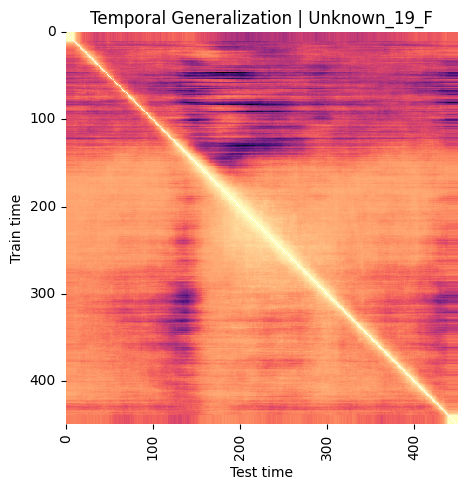

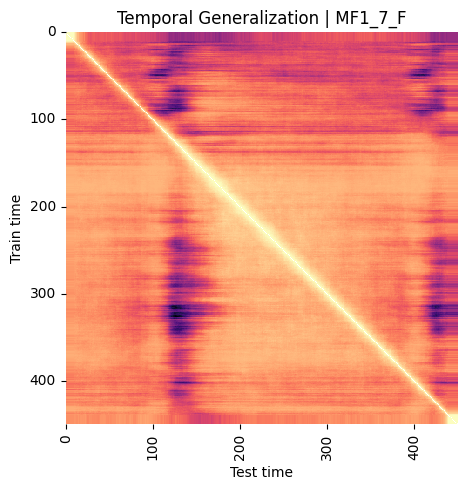

/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


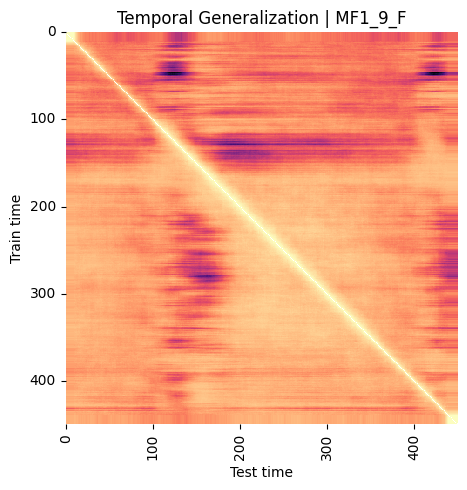

In [83]:
### CATEGORY DECODING GENERALIZATION
# _roi = 'Unknown_19_F' # MF1_8_F, Unknown_19_F, MF1_7_F
for _roi in ['MF1_8_F', 'Unknown_19_F', 'MF1_7_F', 'MF1_9_F']:
    X = np.stack(dat[(dat['roi']==_roi) & (dat['p_value']<0.05)]['img_psth'])
    # reorder to (time, samples, features)
    T, I = X.shape[1], X.shape[2]
    data = X.transpose(1,2,0).reshape(T, I, -1)   # (time, images, units)
    
    # simple label: face vs body vs object
    labels = np.zeros(X.shape[2], int)
    labels[img_sets['all_faces']]   = 1
    labels[img_sets['all_bodies']]  = 2
    labels[img_sets['all_objects']] = 3
    
    gen = np.zeros((T, T))
    for t_train in range(T):
        Xtr = data[t_train]
        clf = LinearSVC()
        clf.fit(Xtr, labels)
    
        for t_test in range(T):
            Xte = data[t_test]
            gen[t_train, t_test] = clf.score(Xte, labels)
    
    np.fill_diagonal(gen, np.nan)
    
    fig,ax = plt.subplots(1, 1, figsize=(5,5))
    sns.heatmap(gen, cmap="magma", square=True, cbar=False, ax=ax)
    ax.set_title(f"Temporal Generalization | {_roi}")
    ax.set_xlabel("Test time")
    ax.set_ylabel("Train time")
    
    ax.set_xticks(np.arange(0, 500, 100), np.arange(0, 500, 100))
    ax.set_yticks(np.arange(0, 500, 100), np.arange(0, 500, 100))
    
    plt.tight_layout()
    plt.show()

In [85]:
rois = ['MF1_8_F', 'Unknown_19_F', 'MF1_7_F', 'MF1_9_F']

# compute generalization matrices for all ROIs
gens = {}
for _roi in tqdm(rois):
    X = np.stack(dat[(dat['roi']==_roi) & (dat['p_value']<0.05)]['img_psth'])
    T, I = X.shape[1], X.shape[2]
    data = X.transpose(1,2,0).reshape(T, I, -1)   # (time, images, units)

    labels = np.zeros(I, int)
    labels[img_sets['all_faces']]   = 1
    labels[img_sets['all_bodies']]  = 2
    labels[img_sets['all_objects']] = 3

    gen = np.zeros((T, T))
    for t_train in range(T):
        Xtr = data[t_train]
        clf = LinearSVC()
        clf.fit(Xtr, labels)
        for t_test in range(T):
            Xte = data[t_test]
            gen[t_train, t_test] = clf.score(Xte, labels)

    np.fill_diagonal(gen, np.nan)
    gens[_roi] = gen

 25%|█████████████████████████████████████████                                                                                                                           | 1/4 [08:57<26:52, 537.42s/it]/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 3/4 [15:55<04:53, 293.73s/it]/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
100%|█████████████

/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_85237/224882124.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


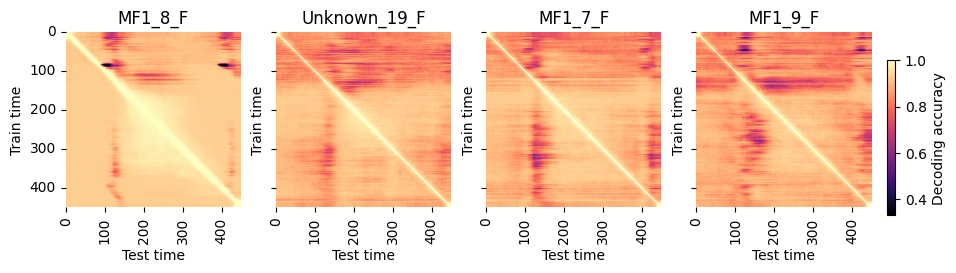

In [99]:
# global vmin/vmax across all ROIs
vmin = np.nanmin([np.nanmin(g) for g in gens.values()])
vmax = np.nanmax([np.nanmax(g) for g in gens.values()])

# plot grid with shared colorbar
fig, axes = plt.subplots(1,4, figsize=(10, 3), sharey=True)
axes = axes.ravel()
ticks = np.arange(0, T, 100)

for ax, _roi in zip(axes, rois):
    gen = gens[_roi]
    hm = sns.heatmap(gen, cmap="magma", square=True, cbar=False,
                     vmin=0.33, vmax=vmax, ax=ax)
    ax.set_title(_roi)
    ax.set_xlabel("Test time")
    ax.set_ylabel("Train time")
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks)

# single shared colorbar at bottom
cbar = fig.colorbar(axes[0].collections[0],
                    ax=axes,
                    orientation='vertical',
                    fraction=0.01,
                    pad=-0.15)
cbar.set_label("Decoding accuracy")

plt.tight_layout()
plt.show()